In [1]:


from typing import Tuple, List, Union
import numpy as np
from matplotlib import pyplot as plt
import meep as mp



In [2]:
def third_harmonic_generation(
    k: float, amp: float = 1.0, nfreq: int = 10, flux_spectrum: bool = True
) -> Union[Tuple[List[float], List[float]], Tuple[float, float]]:
    
    """Computes the transmission spectrum of a plane wave propagating                                             
       through a Kerr medium.                                                                                     
                                                                                                                  
    Args:                                                                                                         
      k: strength of Kerr susceptibility.                                                                         
      amp: amplitude of the incident planewave.                                                                   
      nfreq: number of frequencies in flux spectrum.                                                              
      flux_spectrum: compute the flux spectrum over broad bandwidth (True) or                                     
                     just the two harmonic frequencies ω and 3ω (False).                                          
                                                                                                                  
    Returns:                                                                                                      
      The frequencies and transmitted flux over the flux spectrum or                                              
      the transmitted flux at the harmonic frequencies ω and 3ω.                                                  
    """
    
    sz = 100  # size of cell in z direction                                                                       
    fcen = 1 / 3.0  # center frequency of source                                                                  
    df = fcen / 20.0  # frequency width of source                                                                 
    dpml = 1.0  # PML thickness                                                                                   
                                                                   
    dimensions = 1
    cell = mp.Vector3(0, 0, sz)
    pml_layers = [mp.PML(dpml)]
    resolution = 25
                                                                
    default_material = mp.Medium(index=1, chi3=k)

    sources = [
        mp.Source(
            mp.GaussianSource(fcen, fwidth=df),
            component=mp.Ex,
            center=mp.Vector3(0, 0, -0.5 * sz + dpml),
            amplitude=amp,
        )
    ]

    # frequency range for flux calculation                                                                        
    fmin = fcen / 2.0
    fmax = fcen * 4

    sim = mp.Simulation(
        cell_size=cell,
        sources=sources,
        boundary_layers=pml_layers,
        default_material=default_material,
        resolution=resolution,
        dimensions=dimensions,
    )

    mon_pt = mp.Vector3(0, 0, 0.5 * sz - dpml - 0.5)
    
    if flux_spectrum:
        trans = sim.add_flux(
            0.5 * (fmin + fmax),
            fmax - fmin,
            nfreq,
            mp.FluxRegion(mon_pt),
        )
    else:
        trans1 = sim.add_flux(fcen, 0, 1, mp.FluxRegion(mon_pt))
        trans3 = sim.add_flux(
            3 * fcen, 0, 1, mp.FluxRegion(mon_pt)
        )

    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mon_pt, 1e-6))

    if flux_spectrum:
        freqs = mp.get_flux_freqs(trans)
        trans_flux = mp.get_fluxes(trans)
        return freqs, trans_flux
    else:
        print(
            f"harmonics:, {k}, {amp}, {mp.get_fluxes(trans1)[0]}, "
            f"{mp.get_fluxes(trans3)[0]}"
        )
        return mp.get_fluxes(trans1)[0], mp.get_fluxes(trans3)[0]

In [3]:
nfreq = 400
logk = range(-3, 1)
tflux = np.zeros((nfreq, len(logk)))
for i, lk in enumerate(logk):
    freqs, tflux[:, i] = third_harmonic_generation(
        10**lk, nfreq=nfreq, flux_spectrum=True
    )

-----------
Initializing structure...
time for choose_chunkdivision = 0.00114298 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 100 with resolution 25
time for set_epsilon = 0.00146294 s
-----------


field decay(t = 100.04): 5.345069974777698e-12 / 5.345069974777698e-12 = 1.0
field decay(t = 150.06): 1.0169446296713276e-08 / 1.0169446296713276e-08 = 1.0
field decay(t = 200.08): 4.650911893321058e-06 / 4.650911893321058e-06 = 1.0
field decay(t = 250.1): 0.0005451205008237801 / 0.0005451205008237801 = 1.0
field decay(t = 300.12): 0.01777078053576906 / 0.01777078053576906 = 1.0
field decay(t = 350.14): 0.13039636481724018 / 0.13039636481724018 = 1.0
field decay(t = 400.16): 0.24555052973214989 / 0.24555052973214989 = 1.0
field decay(t = 450.18): 0.24496560125506897 / 0.24555052973214989 = 0.9976178895736085
field decay(t = 500.2): 0.11044114777393739 / 0.24555052973214989 = 0.4497695358035196
field decay(t = 550.22): 0.012780456545355666 / 0.24555052973214989 = 0.052048173381245705
field decay(t = 600.24): 0.00037674024813005836 / 0.24555052973214989 = 0.0015342677066956937
field decay(t = 650.26): 2.4030087682351996e-06 / 0.24555052973214989 = 9.786208854268963e-06
field decay(t = 70

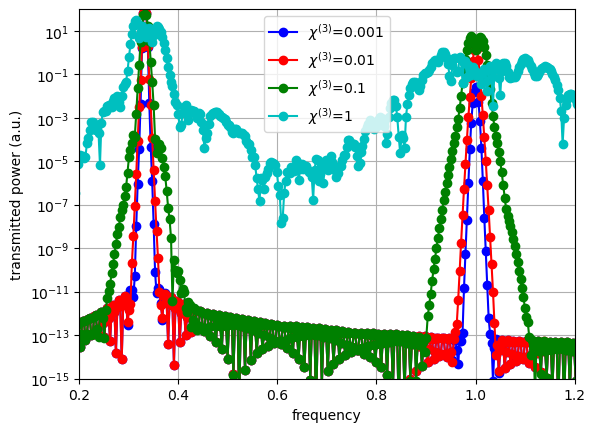

In [4]:


fig, ax = plt.subplots()
ax.semilogy(freqs, tflux[:, 0], "bo-", label=r"$\chi^{(3)}$=0.001")
ax.semilogy(freqs, tflux[:, 1], "ro-", label=r"$\chi^{(3)}$=0.01")
ax.semilogy(freqs, tflux[:, 2], "go-", label=r"$\chi^{(3)}$=0.1")
ax.semilogy(freqs, tflux[:, 3], "co-", label=r"$\chi^{(3)}$=1")
ax.set_xlabel("frequency")
ax.set_ylabel("transmitted power (a.u.)")
ax.set_xlim(0.2, 1.2)
ax.set_ylim(1e-15, 1e2)
ax.legend()
ax.grid(True)
plt.show()



In [5]:


logk = np.arange(-6.0, 0.2, 0.2)
first_order = np.zeros(len(logk))
third_order = np.zeros(len(logk))
for i, lk in enumerate(logk):
    first_order[i], third_order[i] = third_harmonic_generation(
        10**lk, flux_spectrum=False
    )



-----------
Initializing structure...
time for choose_chunkdivision = 0.000208139 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 100 with resolution 25
time for set_epsilon = 0.001544 s
-----------


field decay(t = 100.04): 5.345069974778501e-12 / 5.345069974778501e-12 = 1.0
field decay(t = 150.06): 1.0169446304565756e-08 / 1.0169446304565756e-08 = 1.0
field decay(t = 200.08): 4.6509134041875294e-06 / 4.6509134041875294e-06 = 1.0
field decay(t = 250.1): 0.0005451393864268183 / 0.0005451393864268183 = 1.0
field decay(t = 300.12): 0.01779607955736104 / 0.01779607955736104 = 1.0
field decay(t = 350.14): 0.13167020369297935 / 0.13167020369297935 = 1.0
field decay(t = 400.16): 0.24987915109109593 / 0.24987915109109593 = 1.0
field decay(t = 450.18): 0.2492659288871275 / 0.24987915109109593 = 0.9975459248949311
field decay(t = 500.2): 0.11135321997058951 / 0.24987915109109593 = 0.44562829465510145
field decay(t = 550.22): 0.012792973351210858 / 0.24987915109109593 = 0.051196641637969435
field decay(t = 600.24): 0.00037675013914112524 / 0.24987915109109593 = 0.0015077293863695624
field decay(t = 650.26): 2.4030142102446377e-06 / 0.24987915109109593 = 9.616705514453244e-06
field decay(t = 

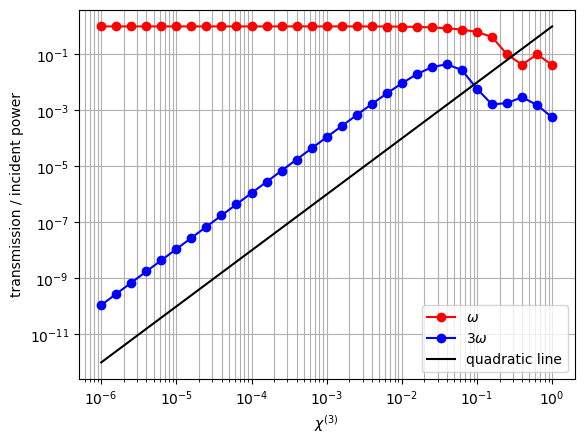

In [6]:
input_flux = first_order[0]
fig, ax = plt.subplots()
ax.loglog(10**logk, first_order / input_flux, "ro-", label=r"$\omega$")
ax.loglog(10**logk, third_order / input_flux, "bo-", label=r"$3\omega$")
ax.loglog(10**logk, (10**logk) ** 2, "k-", label="quadratic line")
ax.set_xlabel(r"$\chi^{(3)}$")
ax.set_ylabel("transmission / incident power")
ax.legend()
ax.grid(True,'both')
plt.show()